## Introduction
L'objectif de ce projet est de construire un moteur de recommandation pour prédire les restaurants dans lesquels les clients sont le plus susceptibles de passer commande, en fonction de la localisation du client, des informations sur le restaurant et de l'historique des commandes du client.

## Analyse des données

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


Il y a 7 fichiers csv dans les données :


In [2]:
for dirname, _, filenames in os.walk('DataProject'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


DataProject\orders.csv
DataProject\SampleSubmission.csv
DataProject\test_customers.csv
DataProject\test_locations.csv
DataProject\train_customers.csv
DataProject\train_locations.csv
DataProject\vendors.csv


In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow, unique):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < unique]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]}')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [4]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna(axis='columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1, cmap='coolwarm') # Choose a colormap (e.g., 'coolwarm')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [5]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.3, 0.2), xycoords='axes fraction', 
                          ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


### orders.csv

In [6]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# orders.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('DataProject/orders.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'orders.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 26 columns


Jetons un rapide coup d'œil sur les données :

In [7]:
df2.head(5)

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83


Graphiques de distribution (histogramme/graphique à barres) des colonnes échantillonnées avec moins de 20 valeurs unique:

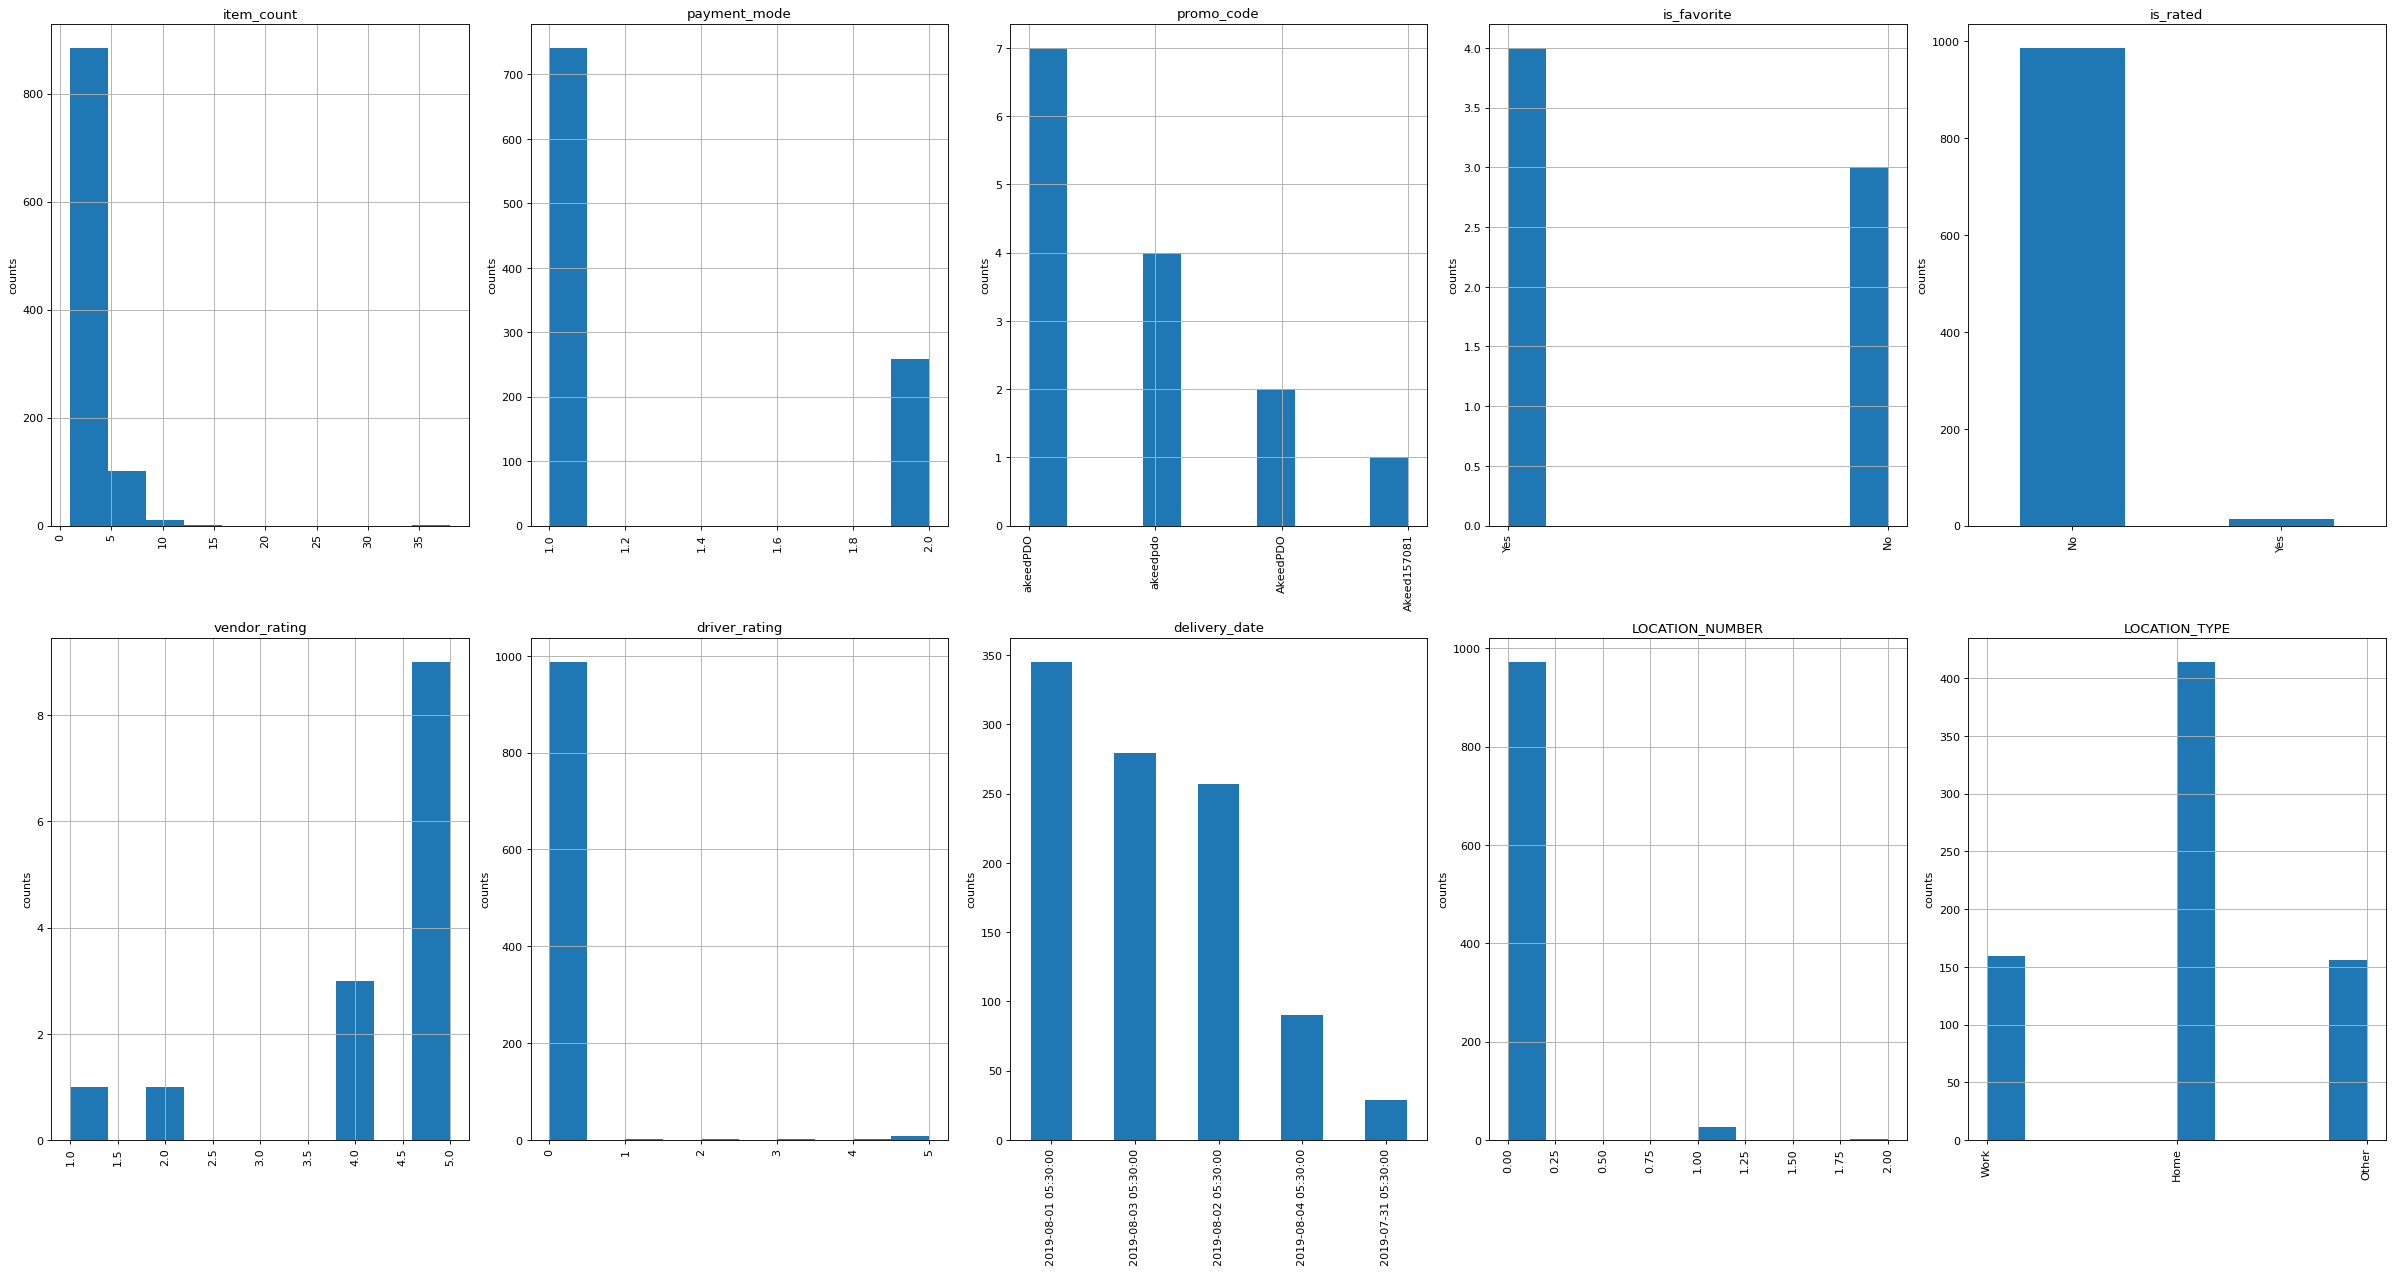

In [8]:
plotPerColumnDistribution(df2, 26, 5, 20)

On remarque que l'on a peu de favoris recensés et peu de notes.

### train_customers.csv

In [9]:
nRowsRead = 1000
df3 = pd.read_csv('DataProject/train_customers.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'train_customers.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 8 columns


Jetons un rapide coup d'œil sur les données :

In [10]:
df3.head(5)

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01


Graphiques de distribution (histogramme/graphique à barres) des colonnes échantillonnées avec moins de 50 valeurs unique:

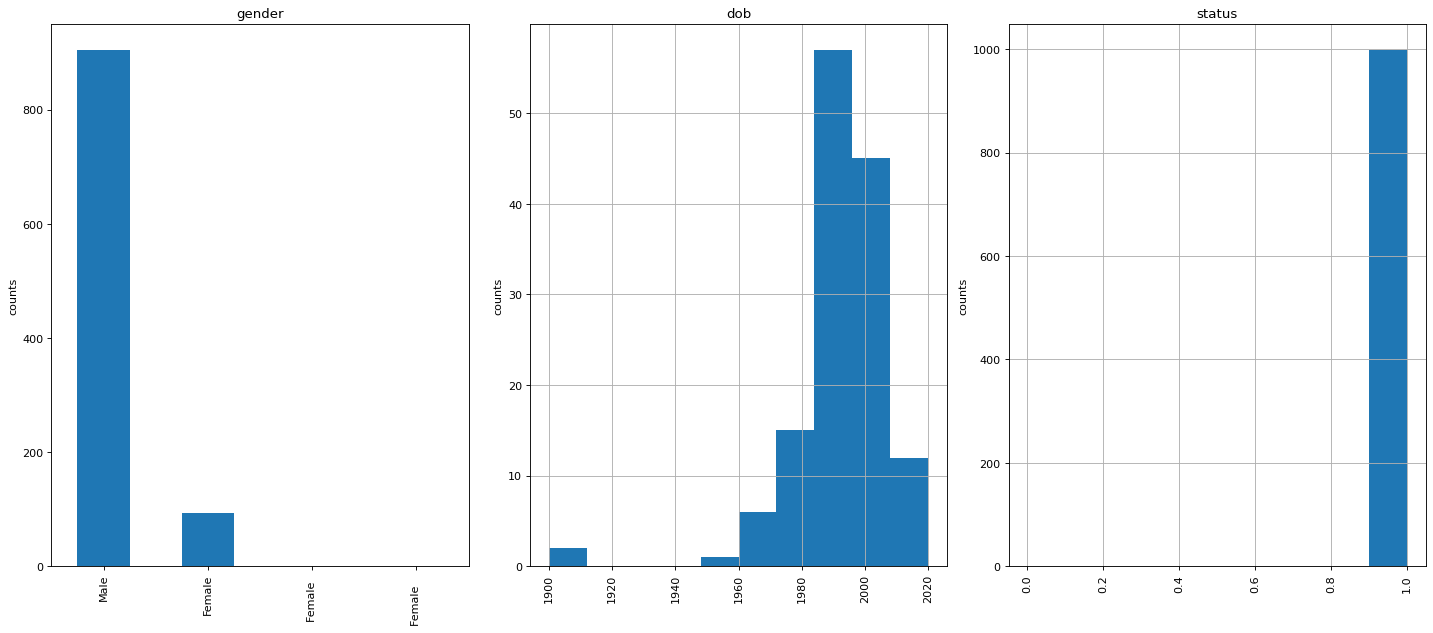

In [11]:
plotPerColumnDistribution(df3, 8, 3, 100)

On va ignorer les dates précedant 1940 qui semblent être des erreurs de la par des clients.

### test_locations.csv

In [12]:
nRowsRead = None
df4 = pd.read_csv('DataProject/train_locations.csv', delimiter=',', nrows = nRowsRead)
df4.dataframeName = 'test_locations.csv'
nRow, nCol = df4.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 59503 rows and 5 columns


Jetons un rapide coup d'œil sur les données :

In [13]:
df4.head(5)

,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.682392,-78.789737
1,02SFNJH,1,NaN,1.679137,0.766823
2,02SFNJH,2,NaN,-0.498648,0.661241
3,RU43CXC,0,Home,0.100853,0.438165
4,BDFBPRD,0,NaN,2.523125,0.733464


Graphiques de distribution (histogramme/graphique à barres) des colonnes échantillonnées avec moins de 20 valeurs unique:

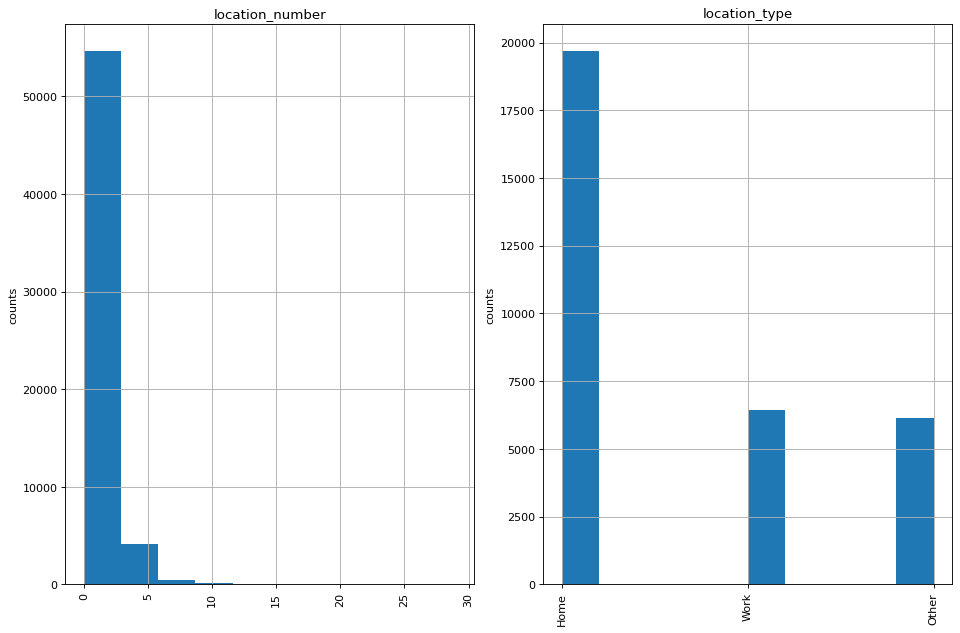

In [14]:
plotPerColumnDistribution(df4, 2, 5, 50)

### vendors.csv

In [15]:
nRowsRead = 1000
df5 = pd.read_csv('DataProject/vendors.csv', delimiter=',', nrows = nRowsRead)
df5.dataframeName = 'vendors.csv'
nRow, nCol = df5.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 100 rows and 59 columns


Jetons un rapide coup d'œil sur les données :

In [16]:
df5.head(5)

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,...,1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,...,1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,...,1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


Graphiques de distribution (histogramme/graphique à barres) des colonnes échantillonnées avec moins de 6 valeurs unique:

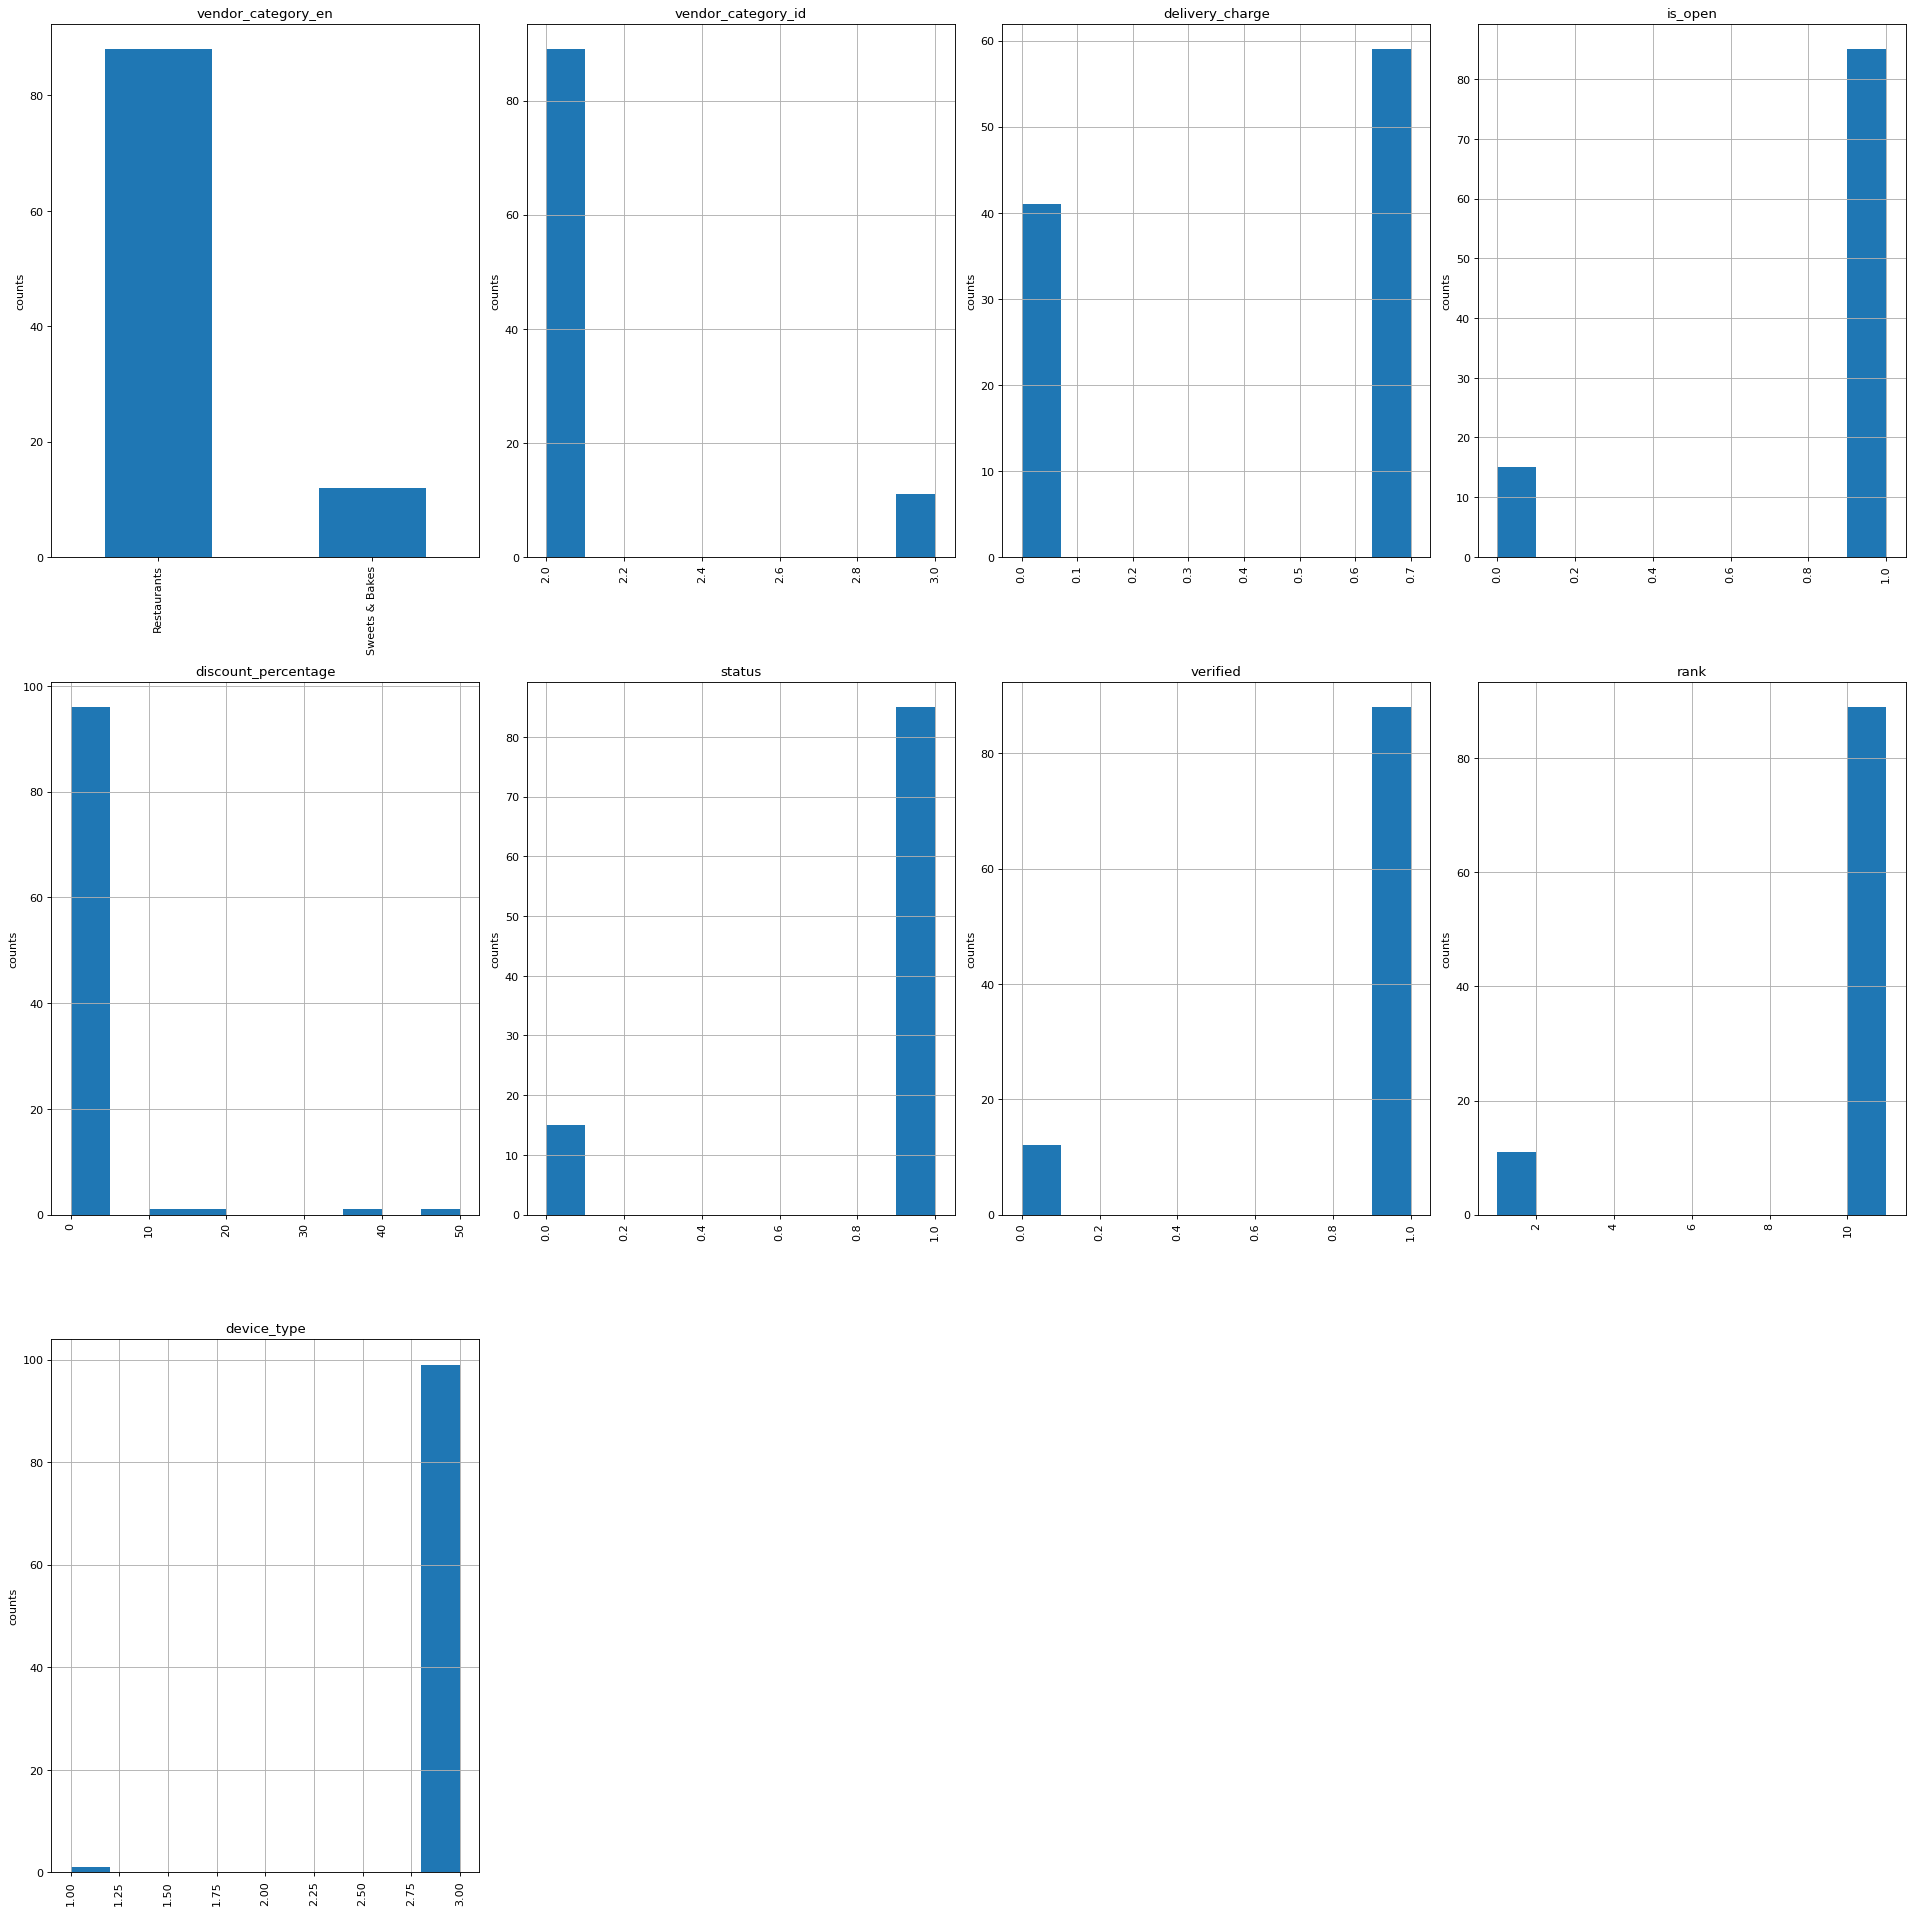

In [17]:
plotPerColumnDistribution(df5, 59, 4, 6)

### Merge

In [18]:
TrainCustomers = pd.read_csv('DataProject/train_customers.csv', delimiter=',').drop_duplicates(['akeed_customer_id'])
TrainLocations = pd.read_csv('DataProject/train_locations.csv', delimiter=',')
Vendors = pd.read_csv('DataProject/vendors.csv', delimiter=',')
Vendors = Vendors[['vendor_category_id', 'delivery_charge', 'discount_percentage', 'is_open', 
                   'verified', 'rank', 'id', 'one_click_vendor',
                   'vendor_tag']]
Orders = pd.read_csv('DataProject/orders.csv', delimiter=',')
merged_df = pd.merge(TrainLocations, TrainCustomers, left_on='customer_id', right_on='akeed_customer_id', how='left',
                     suffixes= ['_loc', '_cust'])
merged_df = pd.merge(Orders, merged_df, left_on=['customer_id','LOCATION_NUMBER'],
                     right_on=['customer_id','location_number'], how='left', suffixes= ['_ord', '_cust'])
merged_df = pd.merge(merged_df, Vendors, left_on='vendor_id', right_on='id',how='left', suffixes= ['_cust', '_ven'])
merged_df.drop(['akeed_customer_id'], axis=1, inplace=True)
merged_df.drop(['id'], axis=1, inplace=True)
merged_df.drop(['LOCATION_NUMBER'], axis=1, inplace=True)
merged_df.dataframeName = "All data"
merged_df

E:\Program Files (x86)\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (15,16,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,created_at_cust,updated_at,vendor_category_id,delivery_charge,discount_percentage,is_open,verified_ven,rank,one_click_vendor,vendor_tag
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,...,2018-11-06 16:46:08,2018-11-06 16:46:07,2.0,0.0,0.0,1.0,1,11,Y,"1,5,91,29,27"
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,...,2019-08-09 00:57:11,2019-10-01 18:53:22,2.0,0.0,0.0,0.0,0,11,Y,"5,8,91,22,42"
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,...,2019-07-03 14:25:10,2019-10-01 18:49:08,2.0,0.7,0.0,1.0,1,11,Y,"4,8,24,2"
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,...,2019-01-04 21:33:08,2019-01-04 21:33:08,2.0,0.0,0.0,1.0,1,1,Y,"1,5,8,52,27"
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,...,2018-10-16 20:44:27,2018-10-16 20:44:26,2.0,0.7,0.0,1.0,1,11,Y,"4,8,24,2"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135298,415507.0,L6LFY6H,1.0,13.3,2,NaN,0.0,0.0,No,No,...,2020-02-09 19:33:04,2020-02-09 19:33:27,2.0,0.0,0.0,1.0,1,11,Y,"4,8,22,32,24,16,28"
135299,415508.0,2GMMVGI,3.0,9.5,1,NaN,0.0,0.0,No,Yes,...,2019-11-03 12:49:01,2019-11-16 17:40:05,2.0,0.0,0.0,1.0,1,11,Y,"5,8,91,27,16"
135300,415510.0,LYTAAV0,4.0,18.2,2,NaN,0.0,0.0,No,No,...,2019-04-15 14:51:34,2019-04-15 14:51:34,2.0,0.7,0.0,1.0,1,11,Y,5
135301,415512.0,NEV9A5D,3.0,7.7,1,NUE5BZAA7,0.0,0.0,No,No,...,2020-02-27 20:15:39,2020-02-27 20:15:53,2.0,0.0,0.0,1.0,1,1,Y,"1,4,5,6,8,91,30,43,48,24"


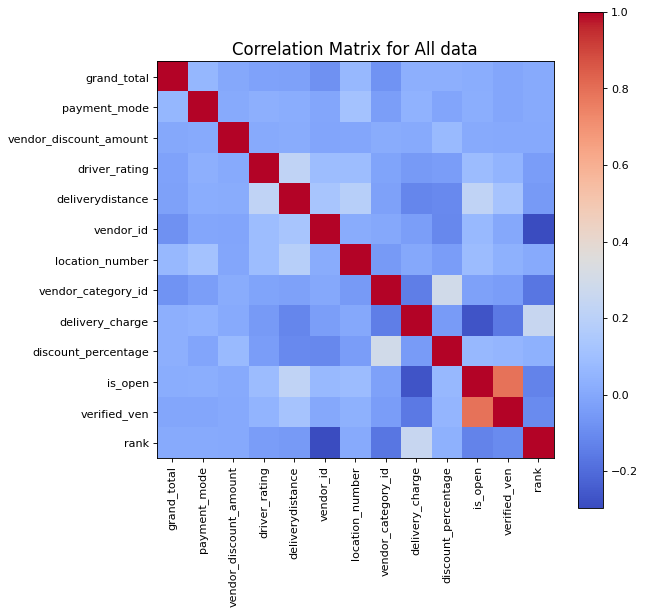

In [19]:
plotCorrelationMatrix(merged_df, 8)

### Features

In [20]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

df = merged_df
# Calculate total number of orders made by each customer from each restaurant
df['total_orders'] = df.groupby(['customer_id', 'vendor_id'])['akeed_order_id'].transform('count')

# Calculate cumulative grand total of orders made by each customer from each restaurant
df['cumulative_grand_total'] = df.groupby(['customer_id', 'vendor_id'])['grand_total'].cumsum()

# Calculate average distance between customer's locations and each restaurant
average_distance = df.groupby('customer_id')['deliverydistance'].mean()
df['average_distance'] = df['customer_id'].map(average_distance)

# Calculate average vendor rating given by each customer
df['average_vendor_rating'] = df.groupby(['customer_id', 'vendor_id'])['vendor_rating'].transform('mean')

# Encode 'is_favorite', 'is_rated', and 'one_click_vendor' using binary encoding
label_encoder = LabelEncoder()
df['is_favorite_encoded'] = label_encoder.fit_transform(df['is_favorite'])
df['is_rated_encoded'] = label_encoder.fit_transform(df['is_rated'])

df['delivered_time'] = pd.to_datetime(df['delivered_time'])
df['order_accepted_time'] = pd.to_datetime(df['order_accepted_time'])


df['actual_delivery_time'] = (df['delivered_time'] - df['order_accepted_time']).dt.total_seconds()
df['delivery_delta'] = abs(df['average_distance'] - df['deliverydistance'])

scaler = MinMaxScaler()
numerical_features = ['total_orders', 'cumulative_grand_total', 'delivery_delta', 'average_vendor_rating',
                      'actual_delivery_time']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [21]:
features = df.groupby(['CID X LOC_NUM X VENDOR'])[['total_orders', 'cumulative_grand_total','delivery_delta',
                                                   'is_favorite_encoded',
                                                   'is_rated_encoded', 'actual_delivery_time']].first()
features = features.fillna(features.median())

### Train set

In [22]:
TrainCustomers = pd.read_csv('DataProject/train_customers.csv', delimiter=',').drop_duplicates(['akeed_customer_id'])
TrainLocations = pd.read_csv('DataProject/train_locations.csv', delimiter=',')

Vendors = pd.read_csv('DataProject/vendors.csv', delimiter=',')
Vendors = Vendors[['vendor_category_id', 'delivery_charge', 'discount_percentage', 'is_open', 'verified', 'id',
                   'vendor_tag', 'latitude', 'longitude']]

TrainCusLoc = pd.merge(TrainLocations, TrainCustomers, left_on='customer_id', right_on='akeed_customer_id', how='left',
                     suffixes= ['_loc', '_cust'])
TrainCusLoc['key'] = 1

# Create a new column in df2 with a constant value to perform a cross-join
Vendors['key'] = 1

# Perform a cross-join or Cartesian product using merge()
result = pd.merge(TrainCusLoc, Vendors, on='key')

# Remove the 'key' column
TrainX = result.drop('key', axis=1)

# Concatenate the columns 'customer_id', 'location_number', and 'id' to create the 'CID X LOC_NUM X VENDOR' index
TrainX['CID X LOC_NUM X VENDOR'] = TrainX['customer_id'] + ' X ' + TrainX['location_number'].astype(str) + ' X ' + TrainX['id'].astype(str)

# Set the 'CID X LOC_NUM X VENDOR' column as the index
TrainX = TrainX.set_index('CID X LOC_NUM X VENDOR')
label_encoder = LabelEncoder()
TrainX['location_type'] = label_encoder.fit_transform(TrainX['location_type'])
TrainX['language'] = label_encoder.fit_transform(TrainX['language'])
TrainX['gender'] = TrainX['gender'].fillna("")
def compare_gender(str):
    if (str == ""):
        return 2
    str = str.lower().replace(" ", "")  # Convertit en minuscules et supprime les espaces
    if str == "female":
        return 0
    elif str == "male":
        return 1
    else:
        return 2

TrainX['gender'] = TrainX['gender'].apply(compare_gender)
TrainX['gender'] = TrainX['gender'].fillna("")
TrainX = TrainX.fillna(TrainX.median())
TrainX

C:\Users\antho\AppData\Local\Temp/ipykernel_30116/1578904754.py:43: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  TrainX = TrainX.fillna(TrainX.median())


,customer_id,location_number,location_type,latitude_x,longitude_x,akeed_customer_id,gender,dob,status,verified_x,...,updated_at,vendor_category_id,delivery_charge,discount_percentage,is_open,verified_y,id,vendor_tag,latitude_y,longitude_y
CID X LOC_NUM X VENDOR,,,,,,,,,,,,,,,,,,,,,
02SFNJH X 0 X 4,02SFNJH,0,3,1.682392,-78.789737,02SFNJH,2,1993.0,1.0,1.0,...,2019-10-01 18:46:33,2.0,0.0,0.0,1.0,1,4,"2,4,5,8,91,22,12,24,16,23",-0.588596,0.754434
02SFNJH X 0 X 13,02SFNJH,0,3,1.682392,-78.789737,02SFNJH,2,1993.0,1.0,1.0,...,2019-10-01 18:46:33,2.0,0.7,0.0,1.0,1,13,"4,41,51,34,27,15,24,16,28",-0.471654,0.744470
02SFNJH X 0 X 20,02SFNJH,0,3,1.682392,-78.789737,02SFNJH,2,1993.0,1.0,1.0,...,2019-10-01 18:46:33,2.0,0.0,0.0,1.0,1,20,"4,8,91,10",-0.407527,0.643681
02SFNJH X 0 X 23,02SFNJH,0,3,1.682392,-78.789737,02SFNJH,2,1993.0,1.0,1.0,...,2019-10-01 18:46:33,2.0,0.0,0.0,1.0,1,23,"5,8,30,24",-0.585385,0.753811
02SFNJH X 0 X 28,02SFNJH,0,3,1.682392,-78.789737,02SFNJH,2,1993.0,1.0,1.0,...,2019-10-01 18:46:33,2.0,0.7,0.0,1.0,1,28,5,0.480602,0.552850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HWELAU8 X 1 X 849,HWELAU8,1,3,-0.067043,0.648221,HWELAU8,1,1993.0,1.0,1.0,...,2018-10-07 21:28:27,2.0,0.0,0.0,1.0,1,849,"1,4,5,6,8,91,30,43,48,24",-1.588060,-0.066441
HWELAU8 X 1 X 855,HWELAU8,1,3,-0.067043,0.648221,HWELAU8,1,1993.0,1.0,1.0,...,2018-10-07 21:28:27,2.0,0.0,0.0,1.0,1,855,"1,5,8,91,30,48,24",2.145206,0.745025
HWELAU8 X 1 X 856,HWELAU8,1,3,-0.067043,0.648221,HWELAU8,1,1993.0,1.0,1.0,...,2018-10-07 21:28:27,2.0,0.0,0.0,1.0,1,856,"1,4,5,6,8,91,30,43,48,24",0.251469,0.483632


In [23]:
from sklearn.preprocessing import MultiLabelBinarizer
from math import radians, sin, cos, sqrt, atan2

mlb = MultiLabelBinarizer()
TrainX['vendor_tag'] = TrainX['vendor_tag'].apply(lambda x: [int(tag) for tag in x.split(',') if tag] if type(x) == str else [x])
TrainX['vendor_tag'] = mlb.fit_transform(TrainX['vendor_tag'])



def calculate_distance(row):
    # Convert latitude and longitude values to radians
    lat_x = radians(float(row['latitude_x']))
    lon_x = radians(float(row['longitude_x']))
    lat_y = radians(float(row['latitude_y']))
    lon_y = radians(float(row['longitude_y']))
    
    # Haversine formula
    dlon = lon_y - lon_x
    dlat = lat_y - lat_x
    a = sin(dlat / 2) ** 2 + cos(lat_x) * cos(lat_y) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  # Earth radius in kilometers
    
    return distance

TrainX['distance'] = TrainX.apply(calculate_distance, axis=1)

# Drop the original columns
TrainX.drop(columns=['customer_id', 'location_number', 'id', 'akeed_customer_id', 'customer_id', 'verified_x',
                     'status', 'created_at', 'updated_at', 'verified_y', 'latitude_x', 'longitude_x',
                     'latitude_y', 'longitude_y'], inplace=True)
TrainX

,location_type,gender,dob,language,vendor_category_id,delivery_charge,discount_percentage,is_open,vendor_tag,distance
CID X LOC_NUM X VENDOR,,,,,,,,,,
02SFNJH X 0 X 4,3,2,1993.0,0,2.0,0.0,0.0,1.0,0,8847.430953
02SFNJH X 0 X 13,3,2,1993.0,0,2.0,0.7,0.0,1.0,0,8845.913268
02SFNJH X 0 X 20,3,2,1993.0,0,2.0,0.0,0.0,1.0,0,8834.488717
02SFNJH X 0 X 23,3,2,1993.0,0,2.0,0.0,0.0,1.0,0,8847.350413
02SFNJH X 0 X 28,3,2,1993.0,0,2.0,0.7,0.0,1.0,0,8821.455686
...,...,...,...,...,...,...,...,...,...,...
HWELAU8 X 1 X 849,3,1,1993.0,0,2.0,0.0,0.0,1.0,1,186.863629
HWELAU8 X 1 X 855,3,1,1993.0,0,2.0,0.0,0.0,1.0,1,246.226148
HWELAU8 X 1 X 856,3,1,1993.0,0,2.0,0.0,0.0,1.0,1,39.866058


In [24]:
# Create a new DataFrame with the indexes from TrainX
TrainY = pd.DataFrame(index=TrainX.index)

# Set the 'target' column to 1 if the index is present in both DataFrames, otherwise set it to 0
TrainY['target'] = TrainY.index.isin(features.index).astype(int)
target_ones = TrainY[TrainY['target'] == 1]
target_ones

,target
CID X LOC_NUM X VENDOR,
02SFNJH X 1 X 192,1
02SFNJH X 1 X 199,1
02SFNJH X 1 X 855,1
02SFNJH X 2 X 159,1
RU43CXC X 0 X 856,1
...,...
HWELAU8 X 1 X 75,1
HWELAU8 X 1 X 188,1
HWELAU8 X 1 X 189,1


### Model

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


Selection des features.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(TrainX, TrainY, test_size=0.4, random_state=42)


In [27]:


y_train = y_train.values.ravel()
y_test =  y_test.values.ravel()

In [28]:

X_train = X_train.fillna(X_train.median())


X_test = X_test.fillna(X_test.median())


In [29]:
X_train

,location_type,gender,dob,language,vendor_category_id,delivery_charge,discount_percentage,is_open,vendor_tag,distance
CID X LOC_NUM X VENDOR,,,,,,,,,,
7QPBIST X 1 X 203,0,1,1993.0,0,2.0,0.7,0.0,0.0,1,59.243612
WJNNHN9 X 2 X 288,1,1,1993.0,0,2.0,0.0,0.0,1.0,0,147.023457
CJ57R00 X 0 X 274,0,1,1993.0,1,3.0,0.7,0.0,0.0,0,12.822216
NIJE0GT X 1 X 189,3,1,1993.0,0,2.0,0.7,0.0,1.0,0,10187.408428
6W5WRVJ X 1 X 106,3,2,1993.0,0,2.0,0.0,0.0,1.0,1,90.790806
...,...,...,...,...,...,...,...,...,...,...
VWXZZUR X 3 X 43,3,0,1997.0,0,2.0,0.7,0.0,1.0,1,8794.250314
GM7WAD1 X 2 X 679,3,1,1993.0,0,2.0,0.7,0.0,1.0,0,63.155750
IZK01RA X 2 X 577,1,1,1993.0,0,2.0,0.7,0.0,1.0,0,8755.691364


In [30]:
X_test

,location_type,gender,dob,language,vendor_category_id,delivery_charge,discount_percentage,is_open,vendor_tag,distance
CID X LOC_NUM X VENDOR,,,,,,,,,,
T05KJWS X 1 X 676,1,2,1993.0,0,2.0,0.7,0.0,1.0,0,72.805154
VGXJ0NP X 3 X 157,0,1,1993.0,0,2.0,0.7,0.0,1.0,0,31.795262
OVMXH07 X 4 X 67,1,2,1993.0,0,2.0,0.0,0.0,1.0,0,80.510977
TDZ7YT6 X 0 X 188,0,2,1993.0,1,2.0,0.7,0.0,1.0,0,56.221041
GN3H67I X 1 X 176,1,2,1993.0,1,2.0,0.7,0.0,1.0,0,5.716117
...,...,...,...,...,...,...,...,...,...,...
5Y6HWET X 3 X 192,0,1,1993.0,0,2.0,0.7,0.0,1.0,0,218.420889
TFAZWGP X 1 X 180,2,1,1993.0,0,2.0,0.7,0.0,0.0,0,8734.678515
DK2P6M5 X 3 X 115,3,1,1993.0,0,2.0,0.0,0.0,1.0,0,91.545133


In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)  # Train the model using the training data

In [ ]:
predictions = knn.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compare the predictions with the actual target values in y_test
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

### Generate submission

In [ ]:
TestCustomers = pd.read_csv('DataProject/test_customers.csv', delimiter=',').drop_duplicates(['akeed_customer_id'])
TestLocations = pd.read_csv('DataProject/test_locations.csv', delimiter=',')

Vendors = pd.read_csv('DataProject/vendors.csv', delimiter=',')
Vendors = Vendors[['vendor_category_id', 'delivery_charge', 'discount_percentage', 'is_open', 'verified', 'id',
                   'vendor_tag', 'latitude', 'longitude']]

TestCusLoc = pd.merge(TestLocations, TestCustomers, left_on='customer_id', right_on='akeed_customer_id', how='left',
                     suffixes= ['_loc', '_cust'])
TestCusLoc['key'] = 1

# Create a new column in df2 with a constant value to perform a cross-join
Vendors['key'] = 1

# Perform a cross-join or Cartesian product using merge()
result = pd.merge(TestCusLoc, Vendors, on='key')

# Remove the 'key' column
TestX = result.drop('key', axis=1)

# Concatenate the columns 'customer_id', 'location_number', and 'id' to create the 'CID X LOC_NUM X VENDOR' index
TestX['CID X LOC_NUM X VENDOR'] = TestX['customer_id'] + ' X ' + TestX['location_number'].astype(str) + ' X ' + TestX['id'].astype(str)

# Set the 'CID X LOC_NUM X VENDOR' column as the index
TestX = TestX.set_index('CID X LOC_NUM X VENDOR')
label_encoder = LabelEncoder()
TestX['location_type'] = label_encoder.fit_transform(TestX['location_type'])
TestX['language'] = label_encoder.fit_transform(TestX['language'])
TestX['gender'] = TestX['gender'].fillna("")
def compare_gender(str):
    if (str == ""):
        return 2
    str = str.lower().replace(" ", "")  # Convertit en minuscules et supprime les espaces
    if str == "female":
        return 0
    elif str == "male":
        return 1
    else:
        return 2

TestX['gender'] = TestX['gender'].apply(compare_gender)
TestX['gender'] = TestX['gender'].fillna("")
TestX = TestX.fillna(TestX.median())
TestX

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from math import radians, sin, cos, sqrt, atan2

mlb = MultiLabelBinarizer()
TestX['vendor_tag'] = TestX['vendor_tag'].apply(lambda x: [int(tag) for tag in x.split(',') if tag] if type(x) == str else [x])
TestX['vendor_tag'] = mlb.fit_transform(TestX['vendor_tag'])



def calculate_distance(row):
    # Convert latitude and longitude values to radians
    lat_x = radians(float(row['latitude_x']))
    lon_x = radians(float(row['longitude_x']))
    lat_y = radians(float(row['latitude_y']))
    lon_y = radians(float(row['longitude_y']))
    
    # Haversine formula
    dlon = lon_y - lon_x
    dlat = lat_y - lat_x
    a = sin(dlat / 2) ** 2 + cos(lat_x) * cos(lat_y) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  # Earth radius in kilometers
    
    return distance

TestX['distance'] = TestX.apply(calculate_distance, axis=1)

# Drop the original columns
TestX.drop(columns=['customer_id', 'location_number', 'id', 'akeed_customer_id', 'customer_id', 'verified_x',
                     'status', 'created_at', 'updated_at', 'verified_y', 'latitude_x', 'longitude_x',
                     'latitude_y', 'longitude_y'], inplace=True)
TestX

On selectionne les memes features

In [ ]:
TestX = TestX.fillna(TestX.median())

In [ ]:
predictions = knn.predict(TestX)

In [ ]:
result_df = pd.DataFrame({
    'CID X LOC_NUM X VENDOR': X.index,  # Assuming the index contains the desired column values
    'target': predictions  # Assuming predictions is a 1D array of int values
})
result_df.to_csv('Submission.csv', index=False)

# Conclusion

Mon plus gros problème au cours de ce projet à été que j 'ai du abandonner de nombreux parametres au fur et à mesure de ma progression car le modele devenait de plus en plus lent à entrainer, bien que j'ai pu trouver pas mal de features intéressante, je n'ai pas pu toute les utiliser.

Je peux ajouter que mon modèle doit certainement avoir des difficultés sur les nouveaux utilisateurs.

Pour conclure, le projet aura bel et bien été un défi car les données pertinaentes ont été difficile à extraire et j ai du faire le tri.